## Задание

### Задание 10

1. Сгенерируйте набор данных для предсказания временных последовательностей. Выполните тренировку RNN
2. Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой библиотеки pytorch.
 
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

### Задание 7

1. Разделить данные на N групп. (возможно, выбрать первые M данных для обучения)
2. Реализовать предсказание ARIMA для 2 (тренировочной группы) на основе 1. Рассчитать MSE.
3. Исследовать качество работы модели в зависимости от параметров (для групп 1-2).
4. Выполнить итеративное предсказание, данные для каждого следующего предсказания обновлять по методу "экспоненциальное среднее".

## Решение

### Импорт

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

from common.progressbar import log_progress

### Настройки

In [2]:
RANDOM_STATE = 42

# Lab 10
EPOCHS = 50

SEQUENCE_LENGTH = 20
LENGTH = 2000
TRAIN_SET_SIZE = 0.6

INPUT_SIZE = 1
HIDDEN_SIZE = 50
OUTPUT_SIZE = 1
NUM_LAYERS = 1

# Lab 7
SPLITS = 2

# Папка лабораторной
DIR_LAB = 'Lab7'

# Папка для загруженных данных
DIR_DATA = 'data'

# Файлы с данными
FILE_DATA_7 = 'ETTm1.csv'

In [3]:
PATH_DATA_7 = os.path.join(DIR_LAB, DIR_DATA, FILE_DATA_7)

In [4]:
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Задание 10

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        
        self.hidden_size=hidden_size

        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)
        
        output = self.fc(out[:, -1, :])
        
        return output

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        
        self.hidden_size=hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)  # Инициализация скрытого состояния
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)  # Инициализация состояния ячейки

        out, _ = self.lstm(x, (h0, c0))

        output = self.fc(out[:, -1, :])
        
        return output

In [8]:
def train_rnn(rnn, criterion, optimizer, dataloader, n_steps, print_every=10):
    rnn.train()
    
    for step in log_progress(range(n_steps), name='Step'):
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.view(-1, SEQUENCE_LENGTH, INPUT_SIZE)

            prediction = rnn(batch_x)

            loss = criterion(prediction, batch_y.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # display loss and predictions
        if (step + 1) % print_every == 0:
            print(f'Step: {step + 1}/{n_steps} - Loss {loss.item():.5f}')
            #plt.plot(time_steps[1:], x, 'r.') # input
            #plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            #plt.show()
    
    return rnn

#### Датасет

In [9]:
class SinusoidDataset(Dataset):
    def __init__(self, length : int, sequence_length : int, start : int = 0, device=None): 
        self.length = length
        self.sequence_length = sequence_length

        data = np.sin(np.linspace(start, np.pi + start, length)) + np.random.normal(0, 0.01, length)

        self.data = torch.from_numpy(data).float()

        if device is not None:
            self.data = self.data.to(device)

    def __len__(self):
        return self.length - self.sequence_length

    def __getitem__(self, index):
        return self.data[index:index + self.sequence_length], self.data[index + self.sequence_length]

#### Генерация данных

In [10]:
train_size = int(LENGTH * TRAIN_SET_SIZE)
test_size = LENGTH - train_size

In [11]:
train_dataset = SinusoidDataset(train_size, SEQUENCE_LENGTH, device=device)
test_dataset = SinusoidDataset(test_size, SEQUENCE_LENGTH, start=train_size, device=device)

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Обучение моделей

In [13]:
rnn_model = RNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, num_layers=NUM_LAYERS)
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

rnn_model = rnn_model.to(device)
rnn_criterion = nn.MSELoss().to(device)

train_rnn(rnn_model, rnn_criterion, rnn_optimizer, train_dataloader, EPOCHS)

Step: 10/50 - Loss 0.00021
Step: 20/50 - Loss 0.00028
Step: 30/50 - Loss 0.00013
Step: 40/50 - Loss 0.00007
Step: 50/50 - Loss 0.00032


RNN(
  (rnn): RNN(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [14]:
rnn_model.eval()

rnn_predictions = []
test_values = []

with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        #x_batch = x_batch.unsqueeze(-1)

        x_batch = x_batch.view(-1, SEQUENCE_LENGTH, INPUT_SIZE)

        pred = rnn_model(x_batch)

        rnn_predictions.extend(pred.squeeze().tolist())

        test_values.extend(y_batch.squeeze().tolist())

In [15]:
lstm_model = LSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, num_layers=NUM_LAYERS)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

lstm_model = lstm_model.to(device)
lstm_criterion = nn.MSELoss().to(device)

train_rnn(lstm_model, lstm_criterion, lstm_optimizer, train_dataloader, EPOCHS)

Step: 10/50 - Loss 0.00021
Step: 20/50 - Loss 0.00016
Step: 30/50 - Loss 0.00034
Step: 40/50 - Loss 0.00042
Step: 50/50 - Loss 0.00022


LSTM(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [16]:
lstm_model.eval()

lstm_predictions = []

with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        #x_batch = x_batch.unsqueeze(-1)

        x_batch = x_batch.view(-1, SEQUENCE_LENGTH, INPUT_SIZE)

        pred = lstm_model(x_batch)

        lstm_predictions.extend(pred.squeeze().tolist())

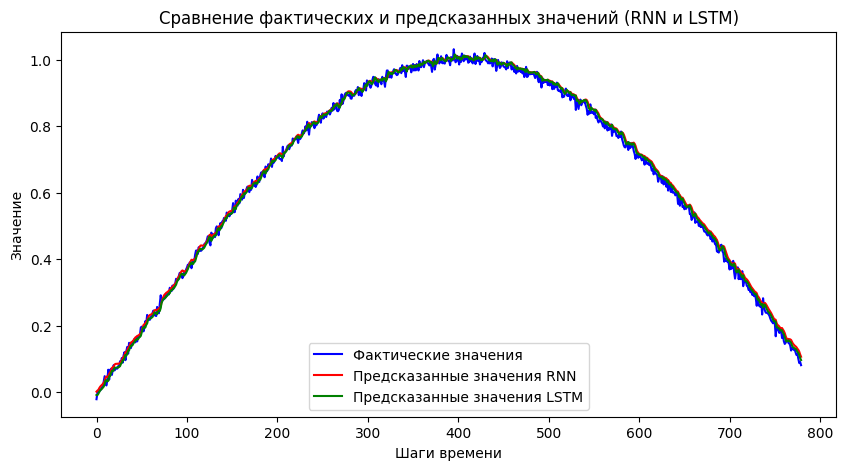

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(test_values, 'b', label='Фактические значения')
plt.plot(rnn_predictions, 'r', label='Предсказанные значения RNN')
plt.plot(lstm_predictions, 'g', label='Предсказанные значения LSTM')
plt.title('Сравнение фактических и предсказанных значений (RNN и LSTM)')
plt.xlabel('Шаги времени')
plt.ylabel('Значение')
plt.legend()
plt.show()

### Задание 7

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#### Загрузка данных
#### 1. Разделить данные на N групп. (возможно, выбрать первые M данных для обучения)

In [71]:
df = pd.read_csv(PATH_DATA_7)

groups = np.array_split(df, SPLITS) 

C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


#### 2. Реализовать предсказание ARIMA для 2 (тренировочной группы) на основе 1. Рассчитать MSE.

In [72]:
train = groups[0].OT
test = groups[1].OT

model = ARIMA(train, order=(3,0,0))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))

print(f'Mean Squared Error: {mean_squared_error(test, predictions)}')

Mean Squared Error: 92.36832833874486


#### 3. Исследовать качество работы модели в зависимости от параметров (для групп 1-2).

In [92]:
arima_params = ParameterGrid({'a': list(range(0, 4)), 'b': list(range(0, 4)), 'c': list(range(0, 4))})

In [93]:
arima_results = []

best_mse = float('inf')
best_params = None

for params in arima_params:
    params_tuple = (*(params.values()),)

    try:
        model = ARIMA(train, order=params_tuple)
        model_fit = model.fit()

        predictions = model_fit.forecast(steps=len(test))

        mse = mean_squared_error(test, predictions)

        print(f'{params_tuple} - MSE: {mse}')

        arima_results.append((*params_tuple, mse))

        if mse < best_mse:
            best_mse = mse
            best_params = params_tuple
    except:
        print(f'Error with parameters {params_tuple}')

(0, 0, 0) - MSE: 92.50025438661712


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 1) - MSE: 92.50516015117314


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 2) - MSE: 92.50719711377708


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 0, 3) - MSE: 92.5042982151774
(0, 1, 0) - MSE: 136.5503960694064
(0, 1, 1) - MSE: 136.61080895020714
(0, 1, 2) - MSE: 136.77568000331667
(0, 1, 3) - MSE: 136.9787730473259
(0, 2, 0) - MSE: 136.55036023295233
(0, 2, 1) - MSE: 448.58684987635434
(0, 2, 2) - MSE: 52.44936955653594
(0, 2, 3) - MSE: 55.99015531156847
(0, 3, 0) - MSE: 1.3121025523400344e+16


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 3, 1) - MSE: 283198.88350425806


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(0, 3, 2) - MSE: 41929136.605317205


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 3, 3) - MSE: 66882878.41358596
(1, 0, 0) - MSE: 92.34727195680478
(1, 0, 1) - MSE: 92.38018705180568
(1, 0, 2) - MSE: 92.36914428799521
(1, 0, 3) - MSE: 92.3646706466209
(1, 1, 0) - MSE: 136.5503960694064
(1, 1, 1) - MSE: 136.67217926783354
(1, 1, 2) - MSE: 137.2087002082253
(1, 1, 3) - MSE: 137.25215289535495
(1, 2, 0) - MSE: 6670436.733328922
(1, 2, 1) - MSE: 53.61287213668197


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 2, 2) - MSE: 49.46435795086779
(1, 2, 3) - MSE: 46.30802835015037
(1, 3, 0) - MSE: 4945290508955504.0
(1, 3, 1) - MSE: 5201670.843936067


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 3, 2) - MSE: 111509592.64432445


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 3, 3) - MSE: 1027.7022137169492
(2, 0, 0) - MSE: 92.38210694834207
(2, 0, 1) - MSE: 92.4082903599046
(2, 0, 2) - MSE: 92.36257320063613
(2, 0, 3) - MSE: 92.35382939599114
(2, 1, 0) - MSE: 136.86270698384772
(2, 1, 1) - MSE: 136.99228379798703
(2, 1, 2) - MSE: 137.21775298634418
(2, 1, 3) - MSE: 137.21026358510642
(2, 2, 0) - MSE: 16242618.776052244
(2, 2, 1) - MSE: 52.152889346523835
(2, 2, 2) - MSE: 46.21714230601652


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 2, 3) - MSE: 47.9101116870421
(2, 3, 0) - MSE: 284309760634419.9
(2, 3, 1) - MSE: 1372106.418944074


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 3, 2) - MSE: 94098446.55980985


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 3, 3) - MSE: 1000870.1631601796
(3, 0, 0) - MSE: 92.36832833874486
(3, 0, 1) - MSE: 92.42580585012827
(3, 0, 2) - MSE: 92.37876720816074
(3, 0, 3) - MSE: 92.40707145259009
(3, 1, 0) - MSE: 136.97130520841085


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 1) - MSE: 136.96598636214958


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 1, 2) - MSE: 137.15282689643334
(3, 1, 3) - MSE: 137.43229328614675
(3, 2, 0) - MSE: 13942162.84344657


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 2, 1) - MSE: 56.25782280038353
(3, 2, 2) - MSE: 48.813914186161085


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 2, 3) - MSE: 466.0434116153173
(3, 3, 0) - MSE: 19100801999642.902


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 3, 1) - MSE: 870669.8712285461
(3, 3, 2) - MSE: 95686980.7850888


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(3, 3, 3) - MSE: 39041.26203963178


In [94]:
print(f'Best parameters: {best_params} - MSE: {best_mse}')

Best parameters: (2, 2, 2) - MSE: 46.21714230601652


#### 4. Выполнить итеративное предсказание, данные для каждого следующего предсказания обновлять по методу "экспоненциальное среднее".

In [96]:
alpha = 0.5

model = ARIMA(train, order=(2, 2, 2)).fit()
predictions = []
forecast_result = model.forecast(steps=1)

current_prediction = forecast_result[0] if isinstance(forecast_result, (list, np.ndarray)) else forecast_result.iloc[0]

for i in range(len(test)):
    true_value = test.iloc[i]
    predictions.append(current_prediction)
    current_prediction = alpha * true_value + (1 - alpha) * current_prediction

mse = mean_squared_error(test, predictions)
print(f'MSE: {mse}')

MSE: 0.1806306890449102


#### 